<a href="https://colab.research.google.com/github/nikhil6553/studious-waffle/blob/main/vaccine_schedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np



In [ ]:
df=pd.read_csv('/content/vaccine-schedule-data.csv', encoding='latin-1')

In [ ]:
print("Before Cleaning:")
print(df.head())
print(df.info())

Before Cleaning:
  ISO_3_CODE COUNTRYNAME WHO_REGION    YEAR VACCINECODE  \
0        ABW       Aruba       AMRO  2023.0  DTAPHIBIPV   
1        ABW       Aruba       AMRO  2023.0  DTAPHIBIPV   
2        ABW       Aruba       AMRO  2023.0  DTAPHIBIPV   
3        ABW       Aruba       AMRO  2023.0  DTAPHIBIPV   
4        ABW       Aruba       AMRO  2023.0     DTAPIPV   

                VACCINE_DESCRIPTION  SCHEDULEROUNDS  TARGETPOP  \
0  DTaP-Hib-IPV (acellular) vaccine             1.0        NaN   
1  DTaP-Hib-IPV (acellular) vaccine             2.0        NaN   
2  DTaP-Hib-IPV (acellular) vaccine             3.0        NaN   
3  DTaP-Hib-IPV (acellular) vaccine             4.0    B_2YL_W   
4      DTaP-IPV (acellular) vaccine             5.0  B_CHILD_W   

  TARGETPOP_DESCRIPTION   GEOAREA AGEADMINISTERED SOURCECOMMENT  
0       General/routine  NATIONAL              M2           NaN  
1       General/routine  NATIONAL              M4           NaN  
2       General/routine  NATIONAL

In [ ]:
# Cleaning
# 1. Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()


In [ ]:
# 2. Handle missing values
df = df.fillna(method="ffill").fillna(0)


/tmp/ipython-input-1099532589.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(0)


In [ ]:
# 3. Normalize percentages (if values are >1 and ≤100, convert to decimal)
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].max() > 1 and df[col].max() <= 100:
        df[col] = df[col] / 100.0


In [ ]:
# 4. Standardize date columns
for col in df.columns:
    if "date" in col.lower() or "year" in col.lower():
        df[col] = pd.to_datetime(df[col], errors="coerce")

In [ ]:
print("\nAfter Cleaning:")
print(df.head())


After Cleaning:
  iso_3_code countryname who_region                          year vaccinecode  \
0        ABW       Aruba       AMRO 1970-01-01 00:00:00.000002023  DTAPHIBIPV   
1        ABW       Aruba       AMRO 1970-01-01 00:00:00.000002023  DTAPHIBIPV   
2        ABW       Aruba       AMRO 1970-01-01 00:00:00.000002023  DTAPHIBIPV   
3        ABW       Aruba       AMRO 1970-01-01 00:00:00.000002023  DTAPHIBIPV   
4        ABW       Aruba       AMRO 1970-01-01 00:00:00.000002023     DTAPIPV   

                vaccine_description  schedulerounds  targetpop  \
0  DTaP-Hib-IPV (acellular) vaccine            0.01          0   
1  DTaP-Hib-IPV (acellular) vaccine            0.02          0   
2  DTaP-Hib-IPV (acellular) vaccine            0.03          0   
3  DTaP-Hib-IPV (acellular) vaccine            0.04    B_2YL_W   
4      DTaP-IPV (acellular) vaccine            0.05  B_CHILD_W   

  targetpop_description   geoarea ageadministered sourcecomment  
0       General/routine  NATIONAL

In [ ]:
df.to_csv("cleaned_vaccine_data.csv", index=False)
print("\n✅ Cleaned data saved as cleaned_vaccine_data.csv")



✅ Cleaned data saved as cleaned_vaccine_data.csv


Generate SQL Schema & Insert Statements


In [ ]:
# Infer SQL schema
def infer_sql_type(dtype):
    if np.issubdtype(dtype, np.integer):
        return "INT"
    elif np.issubdtype(dtype, np.floating):
        return "FLOAT"
    elif np.issubdtype(dtype, np.datetime64):
        return "DATE"
    else:
        return "VARCHAR(255)"

table_name = "vaccination_data"
columns = []


In [ ]:
for col, dtype in df.dtypes.items():
    sql_type = infer_sql_type(dtype)
    columns.append(f"{col} {sql_type}")


In [ ]:
schema = f"CREATE TABLE {table_name} (\n    id INT PRIMARY KEY AUTO_INCREMENT,\n    " + ",\n    ".join(columns) + "\n);"

print("\n--- SQL Schema ---")
print(schema)


--- SQL Schema ---
CREATE TABLE vaccination_data (
    id INT PRIMARY KEY AUTO_INCREMENT,
    iso_3_code VARCHAR(255),
    countryname VARCHAR(255),
    who_region VARCHAR(255),
    year DATE,
    vaccinecode VARCHAR(255),
    vaccine_description VARCHAR(255),
    schedulerounds FLOAT,
    targetpop VARCHAR(255),
    targetpop_description VARCHAR(255),
    geoarea VARCHAR(255),
    ageadministered VARCHAR(255),
    sourcecomment VARCHAR(255)
);


In [ ]:
# Generate INSERT statements
insert_statements = []
for _, row in df.iterrows():
    values = []
    for val in row:
        if pd.isna(val):
            values.append("NULL")
        elif isinstance(val, (np.int64, int, float, np.float64)):
            values.append(str(val))
        elif isinstance(val, pd.Timestamp):
            values.append(f"'{val.date()}'")
        else:
            values.append(f"'{str(val)}'")
    insert_statements.append(f"INSERT INTO {table_name} ({', '.join(df.columns)}) VALUES ({', '.join(values)});")



In [ ]:
# Save SQL file
with open("vaccination_data.sql", "w", encoding="utf-8") as f:
    f.write(schema + "\n\n")
    for stmt in insert_statements:
        f.write(stmt + "\n")


In [ ]:
print("\n✅ SQL script saved as vaccination_data.sql")



✅ SQL script saved as vaccination_data.sql


Exploratory Data Analysis (EDA):

In [ ]:
# 1. BASIC INSPECTION
# =====================
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Summary Statistics ---")
print(df.describe(include="all").transpose())



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8053 entries, 0 to 8052
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   iso_3_code             8053 non-null   object        
 1   countryname            8053 non-null   object        
 2   who_region             8053 non-null   object        
 3   year                   8053 non-null   datetime64[ns]
 4   vaccinecode            8053 non-null   object        
 5   vaccine_description    8053 non-null   object        
 6   schedulerounds         8053 non-null   float64       
 7   targetpop              8053 non-null   object        
 8   targetpop_description  8053 non-null   object        
 9   geoarea                8053 non-null   object        
 10  ageadministered        8053 non-null   object        
 11  sourcecomment          8053 non-null   object        
dtypes: datetime64[ns](1), float64(1), object

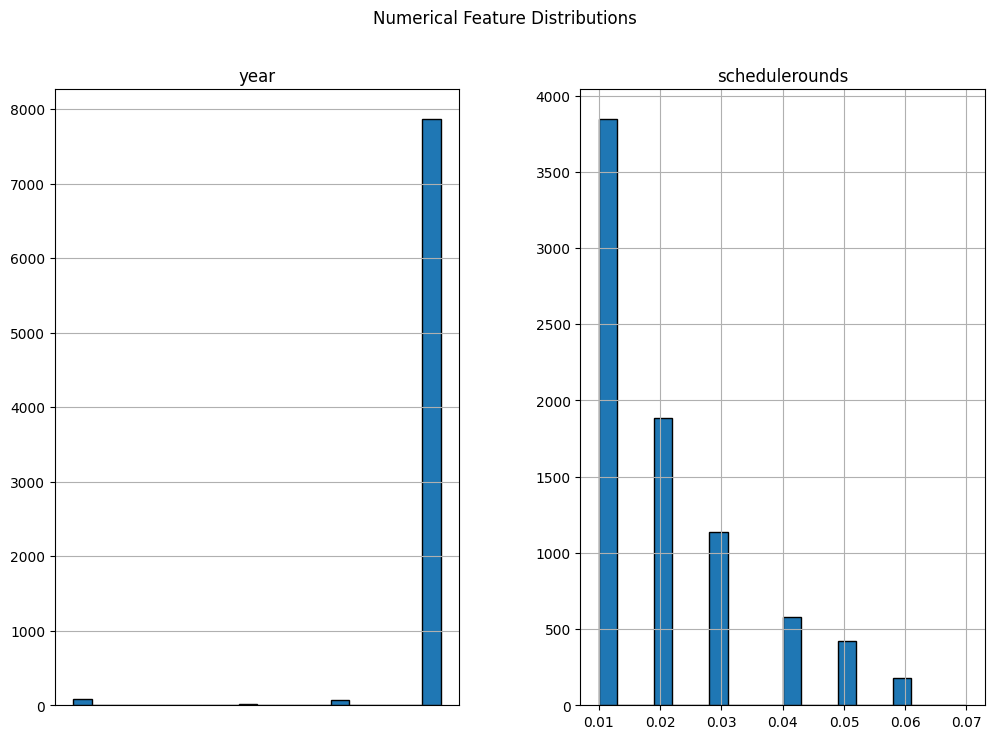

In [ ]:
# 2. DATA DISTRIBUTION
# =====================
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical distributions
df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Numerical Feature Distributions")
plt.show()

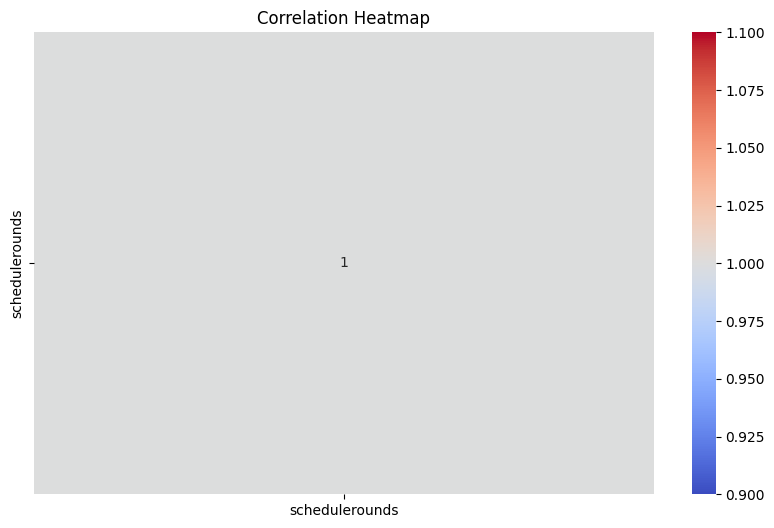

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# 3. TREND ANALYSIS
# =====================
# Vaccination coverage over time
if "year" in df.columns and "coverage_percent" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="year", y="coverage_percent", hue="country", marker="o")
    plt.title("Vaccination Coverage Trend by Country")
    plt.show()

In [ ]:
# 4. GEOGRAPHICAL (if Country column exists)
# =====================
if "country" in df.columns:
    coverage_by_country = df.groupby("country")["coverage_percent"].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    coverage_by_country.plot(kind="bar", color="skyblue")
    plt.title("Average Vaccination Coverage by Country")
    plt.ylabel("Coverage (%)")
    plt.show()


In [ ]:
# 5. RELATIONSHIPS
# =====================
if "coverage_percent" in df.columns and "disease_cases" in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="coverage_percent", y="disease_cases", hue="country")
    plt.title("Vaccination Coverage vs Disease Cases")
    plt.show()

In [ ]:
print("\n✅ EDA completed!")


✅ EDA completed!
